In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimization

In [2]:
stocks = ['AAPL','WMT','TSLA','GE','AMZN','DB','JPM','GS']
# on average there are 252 trading days in a year
NUM_TRADING_DAYS = 252
# we will generate random w (different portfolios)
NUM_PORTFOLIOS = 10000

In [3]:
start_date = '2012-01-01'
end_date = '2022-04-01'

In [4]:
def download_data():
    #name of the stock as key and stock values from 2012-2022
    stock_data = {}
    
    for stock in stocks:
        #closing prices
        ticker = yf.Ticker(stock)
        stock_data[stock]= ticker.history(start= start_date,end=end_date)['Close']
    
    return pd.DataFrame(stock_data)

In [5]:
dataset=download_data()

In [6]:
def show_data(data):
    data.plot(figsize=(10,5))
    plt.show()

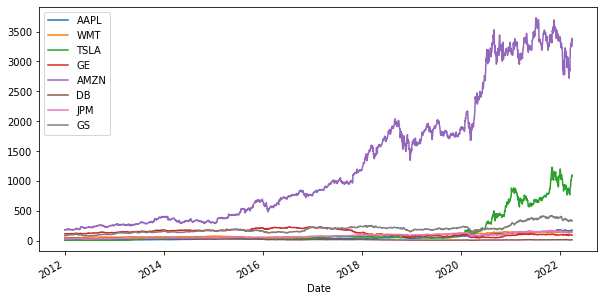

In [7]:
show_data(dataset)

In [8]:
def calculate_return(data):
    log_return= np.log(data/data.shift(1))
    return log_return[1:]

In [9]:
def show_statistics(returns):
    # instead of daily metrics we are after annual metrics
    # mean of annual return
    print(returns.mean() * NUM_TRADING_DAYS)
    print(returns.cov() * NUM_TRADING_DAYS)

In [10]:
def show_mean_variance(returns,weights):
    
    portfolio_return = np.sum(returns.mean()*weights)*NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T,np.dot(returns.cov()*NUM_TRADING_DAYS,weights)))
    print("Expected portfolio mean (return):",portfolio_return)
    print("Expected portfolio volatility (standard deviation):",portfolio_volatility)

In [11]:
def show_portfolios(returns,volatilities):
    plt.figure(figsize=(10,6))
    plt.scatter(volatilities,returns,c=returns/volatilities,marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.show()

In [12]:
def generate_portfolios(returns):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []
    
    for _ in range(NUM_PORTFOLIOS):
        w = np.random.random(len(stocks))
        w /= np.sum(w)
        portfolio_weights.append(w)
        portfolio_means.append(np.sum(returns.mean()*w)*NUM_TRADING_DAYS)
        portfolio_risks.append(np.dot(w.T,np.dot(returns.cov()*NUM_TRADING_DAYS,w)))
    return np.array(portfolio_weights),np.array(portfolio_means),np.array(portfolio_risks)

In [13]:
def statistics(weights,returns):
    portfolio_return = np.sum(returns.mean()*weights)*NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T,np.dot(returns.cov()*NUM_TRADING_DAYS,weights)))
    return np.array([portfolio_return, portfolio_volatility,
                     portfolio_return / portfolio_volatility])

In [14]:
# scipy optimize module can find the minimum of a given function
# the maximum of a f(x) is the minimum of -f(x)
def min_function_sharpe(weights, returns):
    return -statistics(weights, returns)[2]

In [15]:
def optimize_portfolio(weights,returns):
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(len(stocks)))
    return optimization.minimize(fun=min_function_sharpe, x0=weights[0], args=returns
                                 , method='SLSQP', bounds=bounds, constraints=constraints)

In [16]:
def print_optimal_portfolio(optimum, returns):
    print("Optimal portfolio: ", optimum['x'].round(3))
    print("Expected return, volatility and Sharpe ratio: ",
          statistics(optimum['x'].round(3), returns))

In [17]:
def show_optimal_portfolio(opt, rets, portfolio_rets, portfolio_vols):
    plt.figure(figsize=(10, 6))
    plt.scatter(portfolio_vols, portfolio_rets, c=portfolio_rets / portfolio_vols, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.plot(statistics(opt['x'], rets)[1], statistics(opt['x'], rets)[0], 'g*', markersize=20.0)
    plt.show()


In [18]:
dataset = download_data()

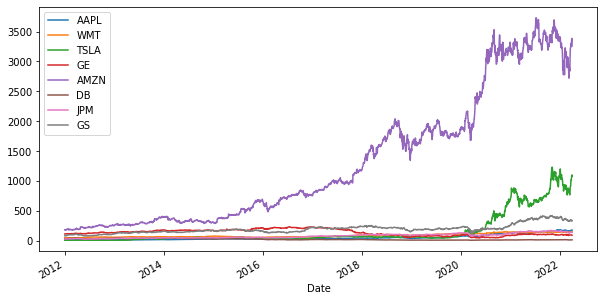

In [19]:
show_data(dataset)

In [20]:
log_daily_returns = calculate_return(dataset)

In [21]:
pweights, means, risks = generate_portfolios(log_daily_returns)

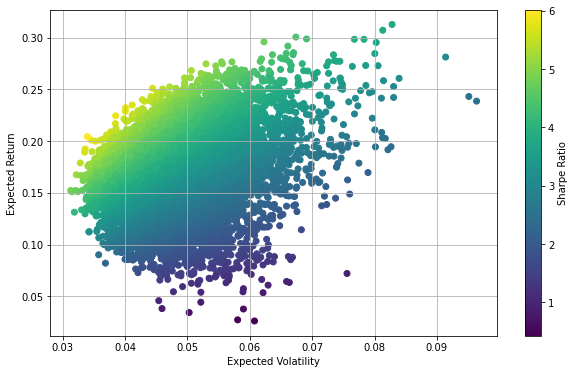

In [22]:
show_portfolios(means, risks)

In [23]:
optimum = optimize_portfolio(pweights, log_daily_returns)

In [24]:
print_optimal_portfolio(optimum, log_daily_returns)

Optimal portfolio:  [0.24  0.227 0.182 0.    0.277 0.    0.074 0.   ]
Expected return, volatility and Sharpe ratio:  [0.27094872 0.21925844 1.23575048]


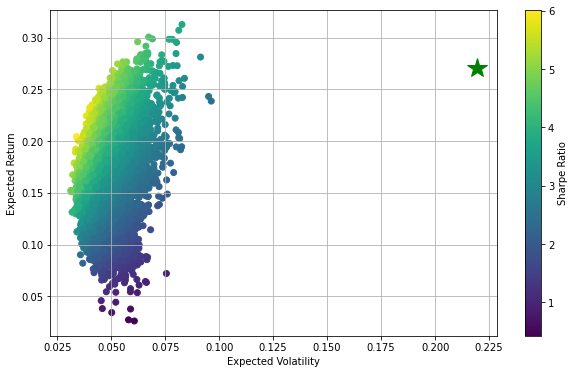

In [25]:
show_optimal_portfolio(optimum, log_daily_returns, means, risks)